In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [36]:
#ds = tfds.load('oxford_iiit_pet', shuffle _files = True)
dataset = tfds.load('oxford_iiit_pet', shuffle_files=True)


In [37]:
print(dataset.keys())

dict_keys(['train', 'test'])


In [38]:
ds = dataset['train'].take(1)
print(ds)

<_TakeDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [39]:
for example in ds:
  image = example["image"]
  mask = example["segmentation_mask"]
  print(image.shape, mask.shape)
  print('Image: ', tf.reduce_min(image),tf.reduce_max(image))
  print('Mask: ',tf.unique(tf.reshape(mask,[-1])))

(500, 334, 3) (500, 334, 1)
Image:  tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(255, shape=(), dtype=uint8)
Mask:  Unique(y=<tf.Tensor: shape=(3,), dtype=uint8, numpy=array([2, 3, 1], dtype=uint8)>, idx=<tf.Tensor: shape=(167000,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


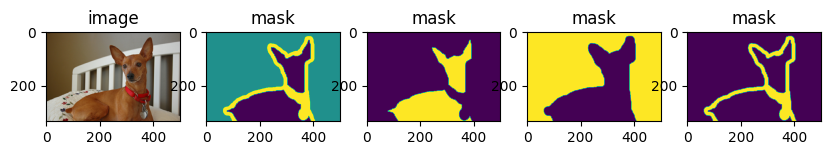

In [40]:
for example in ds:
  image = example["image"]
  mask = example["segmentation_mask"]

plt.figure(figsize =(10,10))
plt.subplot(1,5,1)
plt.title('image')
plt.imshow(image)

plt.subplot(1,5,2)
plt.title('mask')
plt.imshow(mask)

plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(mask==1)

plt.subplot(1,5,4)
plt.title('mask')
plt.imshow(mask==2)

plt.subplot(1,5,5)
plt.title('mask')
plt.imshow(mask==3)



## Pre-Processing

In [35]:
#Standerize the image data across all the samples

In [42]:
def normalize_img(data):
  image = data['image']
  mask = data['segmentation_mask']
  image = tf.image.resize(image,[128,128])
  mask = tf.image.resize(mask,[128,128], method = 'nearest')

  image = tf.cast(image, tf.float32) / 255.0
  mask = tf.cast(mask-1, tf.float32)
  return image, mask

ds_train = dataset['train'].map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [45]:
ds_test = dataset['test'].map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [46]:
print(ds_train)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


### Model Building

In [56]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(1))
model.build((None, 16))

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (580.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:

inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_8 (Dense)             (None, 4)                 16        
                                                                 
 dense_9 (Dense)             (None, 5)                 25        
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=[128,128,3],include_top = False)
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [60]:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Encoder
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [61]:
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-phs5m8i_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-phs5m8i_
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=c698c212a43ecec07b3c9e29bbff2c1ebd5d2835ece66fce3f7dedfb85f1b8d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-8nhw6z53/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [62]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [63]:
model = unet_model(3)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        [(None, 64, 64, 96),         1841984   ['input_4[0][0]']             
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

In [64]:
# Image Segm: Per-pixel classification

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
29/29 [==============================] - 49s 1s/step - loss: 0.6861 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.6757 - val_sparse_categorical_accuracy: 0.7596
Epoch 2/10
29/29 [==============================] - 10s 334ms/step - loss: 0.3529 - sparse_categorical_accuracy: 0.8712 - val_loss: 0.5186 - val_sparse_categorical_accuracy: 0.8094
Epoch 3/10
29/29 [==============================] - 10s 340ms/step - loss: 0.2998 - sparse_categorical_accuracy: 0.8878 - val_loss: 0.3429 - val_sparse_categorical_accuracy: 0.8749
Epoch 4/10
29/29 [==============================] - 10s 341ms/step - loss: 0.2753 - sparse_categorical_accuracy: 0.8955 - val_loss: 0.3066 - val_sparse_categorical_accuracy: 0.8861
Epoch 5/10
29/29 [==============================] - 10s 337ms/step - loss: 0.2593 - sparse_categorical_accuracy: 0.9006 - val_loss: 0.2910 - val_sparse_categorical_accuracy: 0.8922
Epoch 6/10
29/29 [==============================] - 10s 333ms/step - loss: 0.2473 - sparse_categor

## Evaluation

4/4 [==============================] - 4s 24ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 25ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 24ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 27ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============

<ipython-input-65-ac42b2fa21f2>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 27ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 27ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
3/3 [==============================] - 3s 849ms/step
(85, 128, 128, 3) (85, 128, 128, 1) (85, 128, 128, 1)


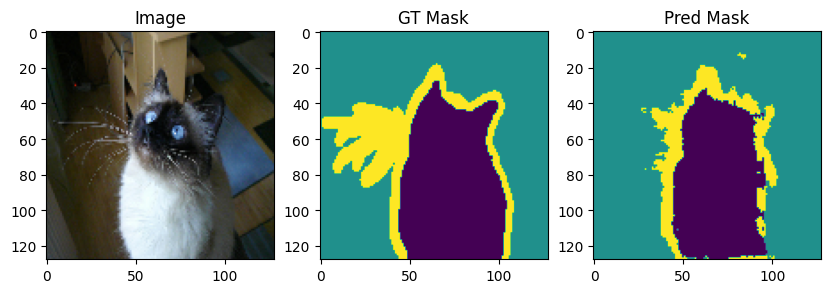

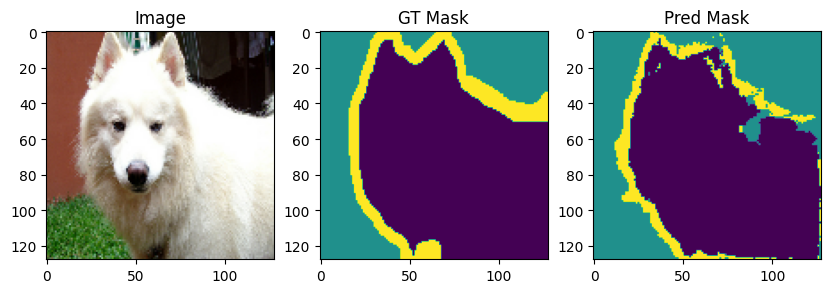

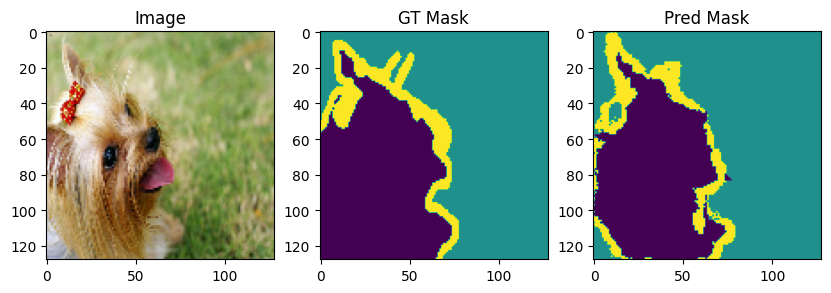

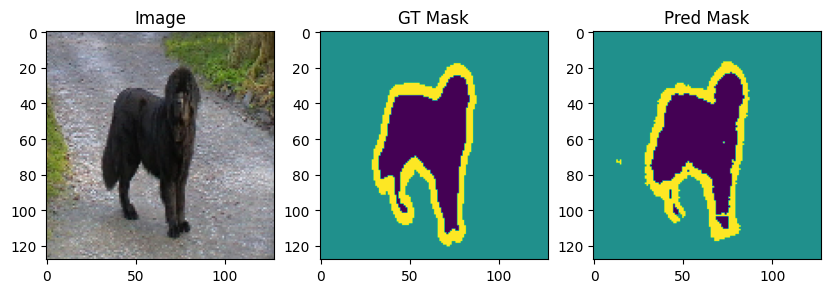

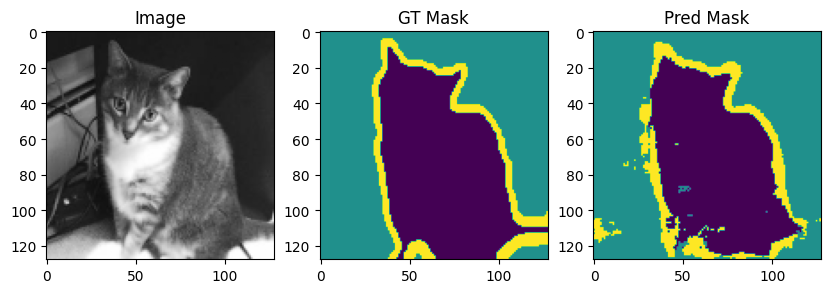

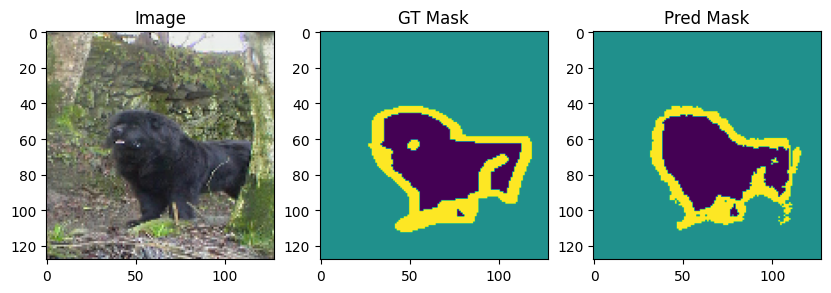

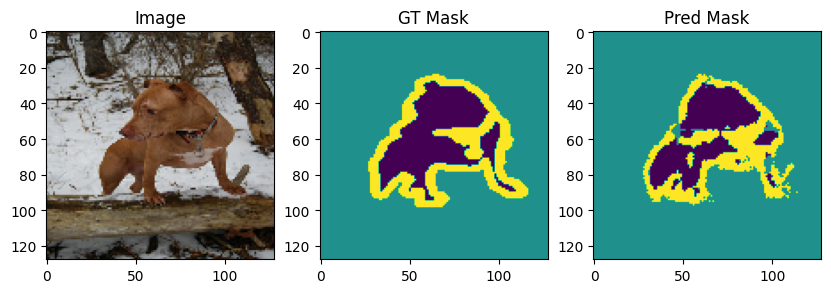

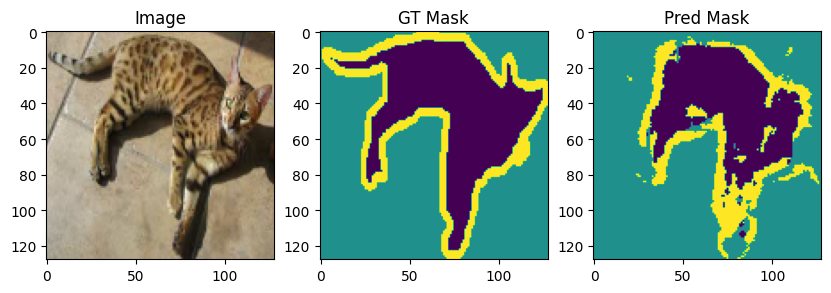

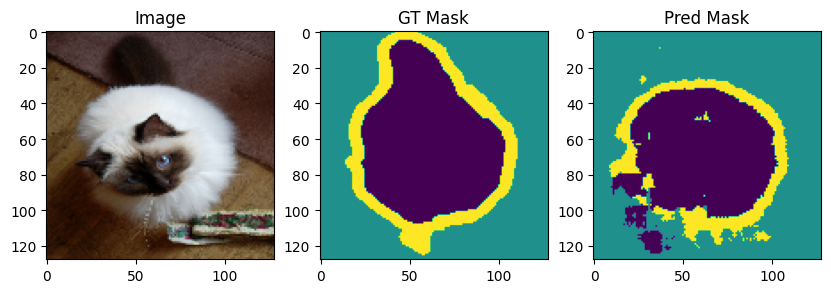

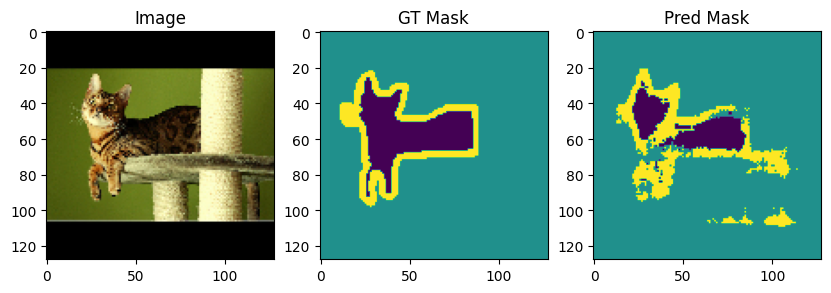

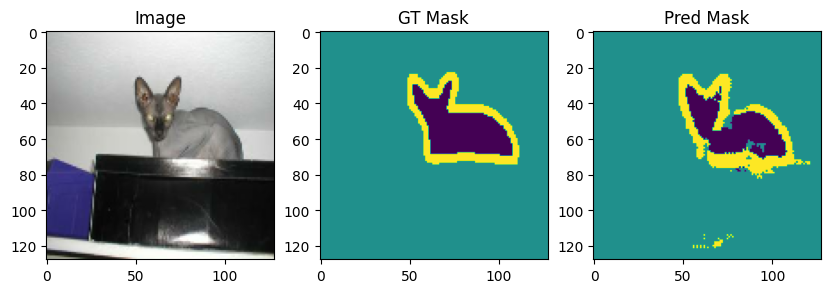

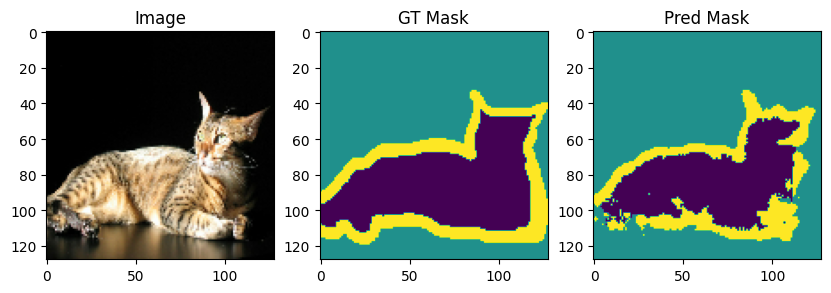

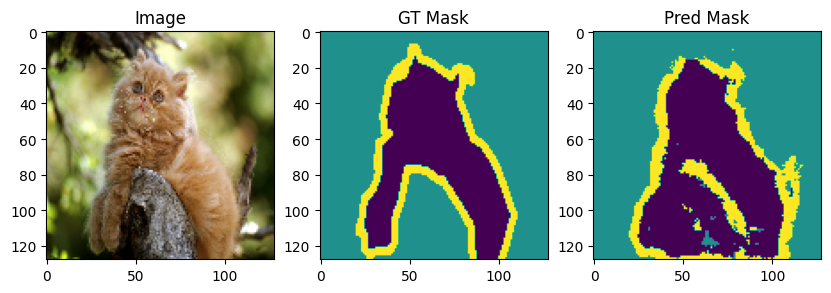

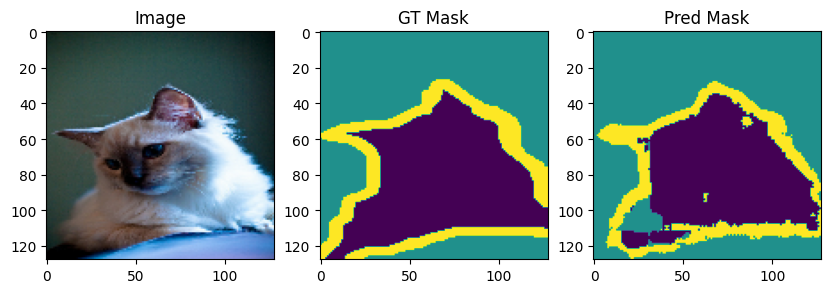

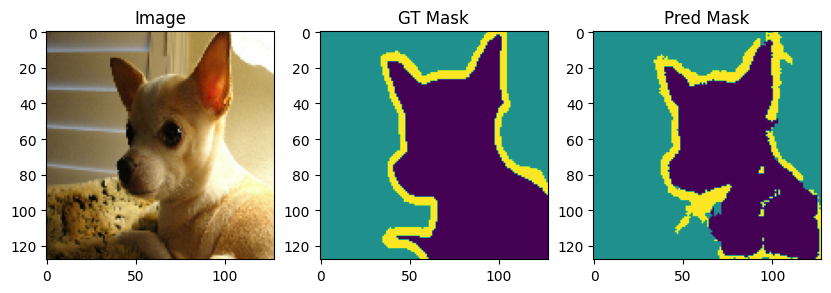

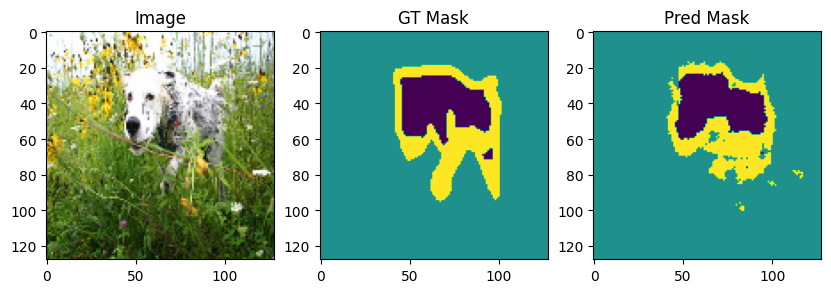

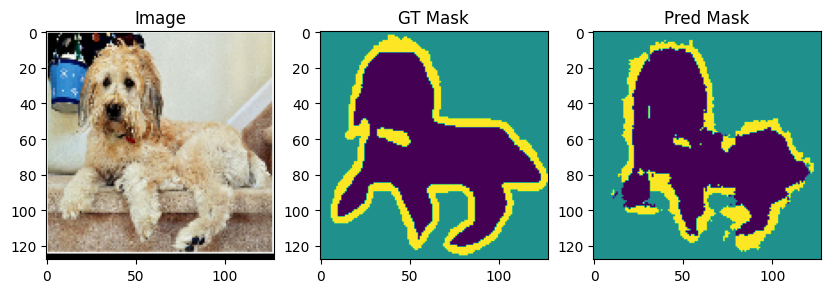

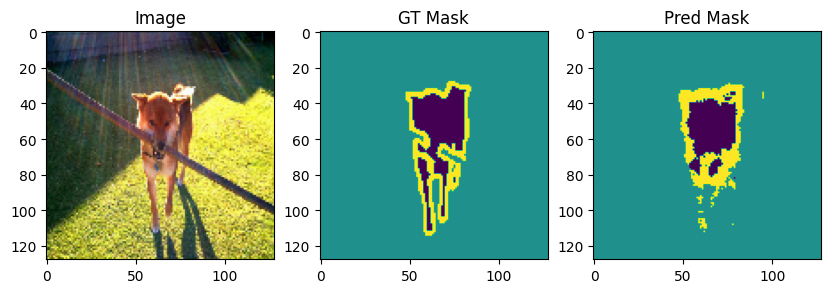

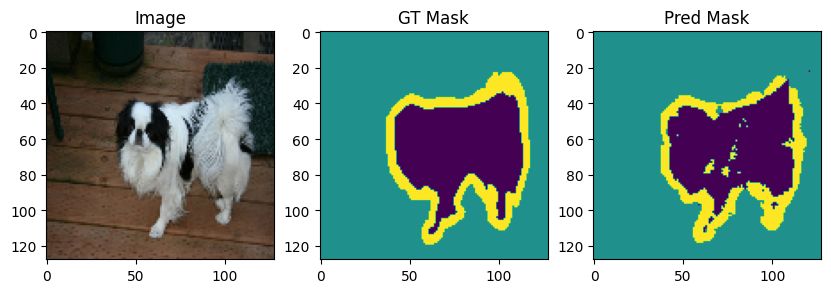

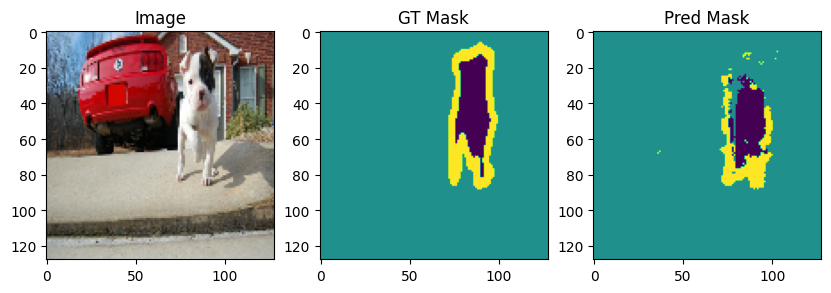

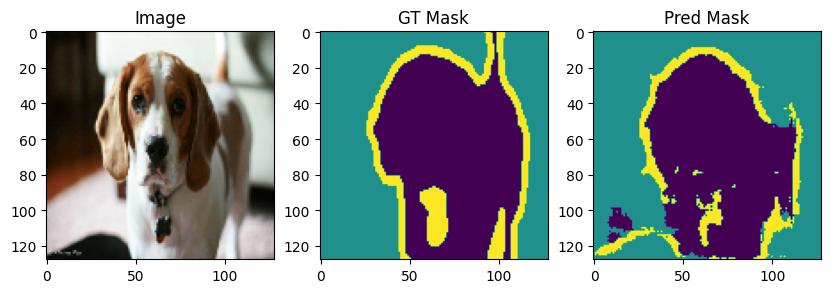

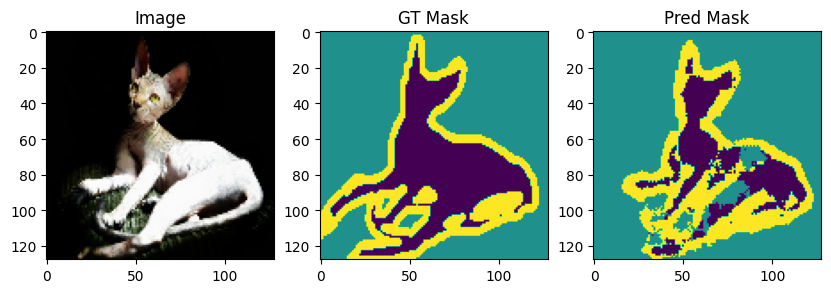

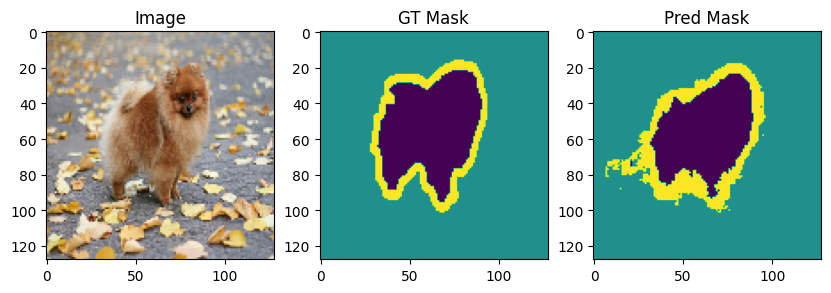

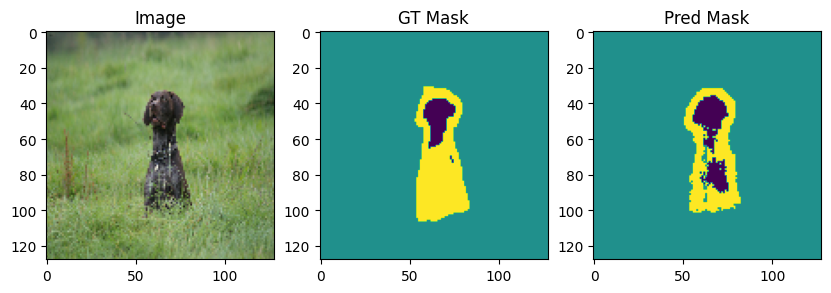

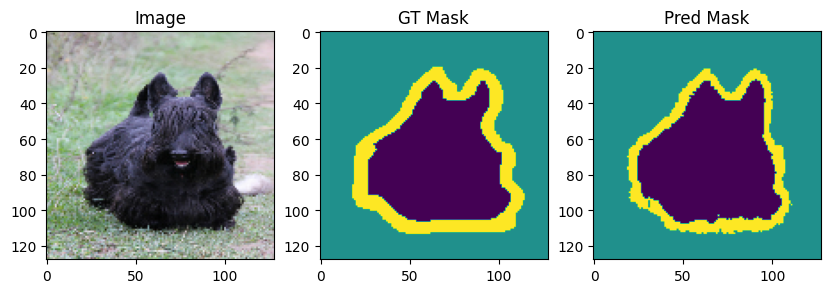

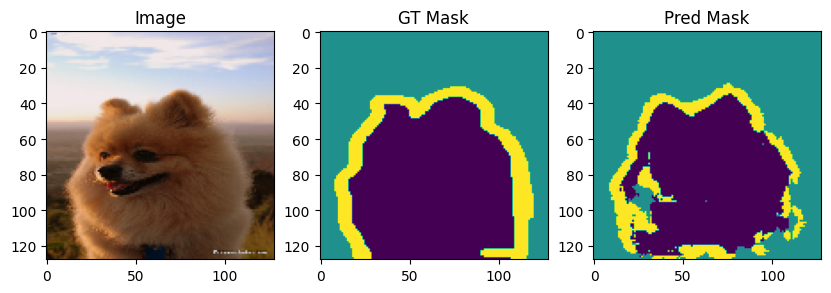

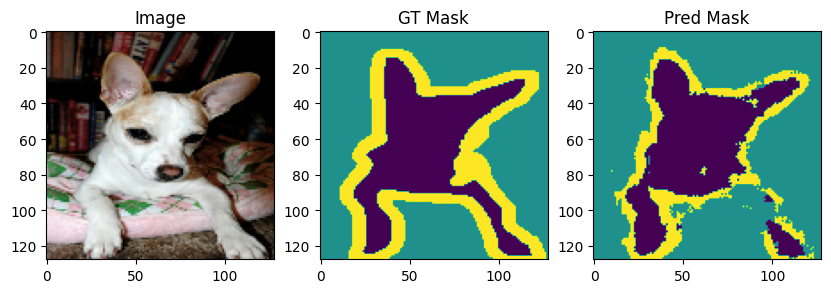

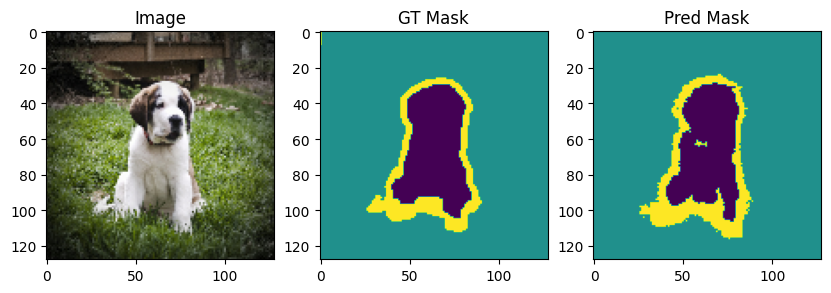

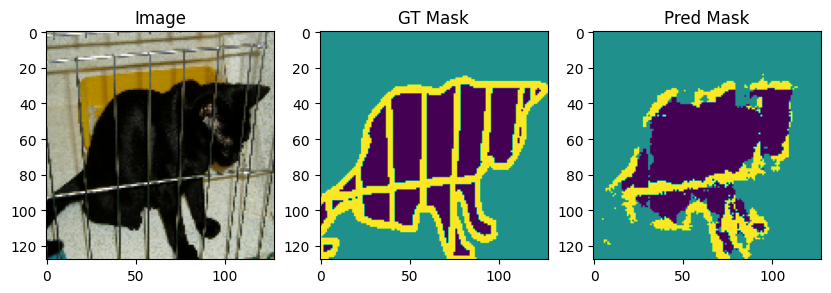

In [65]:
for (image, mask) in ds_test:
  pred_mask = model.predict(image)
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  print(image.shape, mask.shape, pred_mask.shape)

  plt.figure(figsize=(10, 10))
  plt.subplot(1, 3, 1)
  plt.title('Image')
  plt.imshow(image[0])

  plt.subplot(1, 3, 2)
  plt.title('GT Mask')
  plt.imshow(mask[0])

  plt.subplot(1, 3, 3)
  plt.title('Pred Mask')
  plt.imshow(pred_mask[0])